In [1]:
%matplotlib inline
import keras
from keras import backend as K
import scipy
import skimage
import skimage.transform
import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.


In [2]:
content = scipy.ndimage.imread("images/me.jpg",mode=None)/255.0
style = scipy.ndimage.imread("images/style.png",mode="RGB")/255.0

shape = (round(style.shape[0]/3,0),round(style.shape[1]/3,0))


content_resized = skimage.transform.resize(content,shape)
style_resized = skimage.transform.resize(style,shape)

content_resized = content_resized.astype(np.float32)
style_resized = style_resized.astype(np.float32)


/home/crosarko/anaconda3/envs/ai_snippets/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  if __name__ == '__main__':
/home/crosarko/anaconda3/envs/ai_snippets/lib/python3.5/site-packages/ipykernel/__main__.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  from ipykernel import kernelapp as app
/home/crosarko/anaconda3/envs/ai_snippets/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


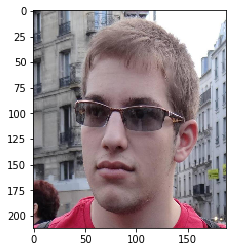

In [3]:
plt.imshow(content_resized)

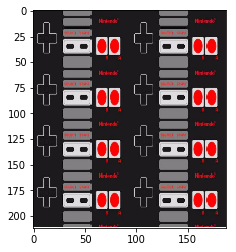

In [4]:
plt.imshow(style_resized)

In [5]:
model = keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet')

In [6]:
for a in model.layers:
    print(a.name)

input_1
conv1_pad
conv1
bn_conv1
activation_1
max_pooling2d_1
res2a_branch2a
bn2a_branch2a
activation_2
res2a_branch2b
bn2a_branch2b
activation_3
res2a_branch2c
res2a_branch1
bn2a_branch2c
bn2a_branch1
add_1
activation_4
res2b_branch2a
bn2b_branch2a
activation_5
res2b_branch2b
bn2b_branch2b
activation_6
res2b_branch2c
bn2b_branch2c
add_2
activation_7
res2c_branch2a
bn2c_branch2a
activation_8
res2c_branch2b
bn2c_branch2b
activation_9
res2c_branch2c
bn2c_branch2c
add_3
activation_10
res3a_branch2a
bn3a_branch2a
activation_11
res3a_branch2b
bn3a_branch2b
activation_12
res3a_branch2c
res3a_branch1
bn3a_branch2c
bn3a_branch1
add_4
activation_13
res3b_branch2a
bn3b_branch2a
activation_14
res3b_branch2b
bn3b_branch2b
activation_15
res3b_branch2c
bn3b_branch2c
add_5
activation_16
res3c_branch2a
bn3c_branch2a
activation_17
res3c_branch2b
bn3c_branch2b
activation_18
res3c_branch2c
bn3c_branch2c
add_6
activation_19
res3d_branch2a
bn3d_branch2a
activation_20
res3d_branch2b
bn3d_branch2b
activation

In [7]:
content_layer = model.get_layer("activation_19").output
style_layer = model.get_layer("add_1").output

The snippet below comes from the [fast.ai course](http://course.fast.ai/lessons/lesson8.html).

In [ ]:
class Evaluator(object):
    def __init__(self, f, shp): self.f, self.shp = f, shp
        
    def loss(self, x):
        loss_, self.grad_values = self.f([x.reshape(self.shp)])
        return loss_.astype(np.float64)

    def grads(self, x): return self.grad_values.flatten().astype(np.float64)

def generate_function(model,layer,input): 
    input = np.expand_dims(input,0)
    local_model = keras.Model(model.input, layer)
    local_targ = K.variable(model.predict(input))
    loss = keras.metrics.mse(layer, local_targ)
    grads = K.gradients(loss, model.input)
    fn = K.function([model.input], [loss]+grads)
    evaluator = Evaluator(fn, input.shape)
    return fn,evaluator

content_function = generate_function(model,content_layer,content_resized)
style_function = generate_function(model,style_layer,style_resized)


In [1]:
style_resized.shape

NameError: name 'style_resized' is not defined